<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Keras_functional_model_with_multiple_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 26th October, 2021
# Myfolder: /home/ashok/Documents/mercari_price_challenge
# Ref: https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl
# VM: lubuntu_deeplearning_II
#
#     Objectives:
#                1. Learning functional model of keras
#                2. Functional model with multiple inputs
#                3. Applying deeplearning to structured tables
#                4. Vector conversion of categorical variables
#                   as also descriptive text


## [Problem](https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview)

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost $335 and the other cost $9.99. Can you guess which one’s which?

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

Note that, because of the public nature of this data, this competition is a “Kernels Only” competition. In the second stage of the challenge, files will only be available through Kernels and you will not be able to modify your approach in response to new data. Read more details in the data tab and Kernels FAQ page. 


## Call libraries

In [1]:
# 1.0 Call libraries
# 1.1 Data manipulation libraries
import numpy as np
import pandas as pd

# 1.1 sklearn libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# 1.2 For plotting NN model
#  conda install -c anaconda graphviz
#  conda install -c anaconda pydot
from skimage import io
import pydot

# 1.3 Keras model components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# 1.3.1 For text (word) to integer transformation
from tensorflow.keras.preprocessing.text import Tokenizer
# 1.3.2 For making all integer sequences of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 1.3.3 Import backend to invoke tensorflow commands
from tensorflow.keras import backend as K

# 1.4 Plotting libraries
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline 

# 1.5 Misc
import math, time, os,gc

In [2]:
# 1.6 Print all outputs from a cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## RMSLE 
Root mean squared Logaritmic error. See [here](https://hrngok.github.io/posts/metrics/#Root-Mean-Squared-Logaritmic-Error-(RMSLE)) and also [this article](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a).

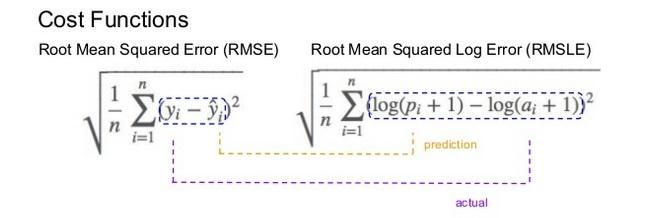

Mechanism:  
It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values. RMSLE adds 1 to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible 0 (zero) values. As a result, the function can be used if actual or predicted have zero-valued elements. But this function is not appropriate if either is negative valued.


Functionality:
The expression: `log(pi+1)−log(ai+1)`
can be written as `log((pi+1)/(ai+1))` <br>
RMSLE measures the ratio of predicted and actual.

#### RMSLE is preferable when
> Targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc <br>
> We care about percentage errors rather than the absolute value of errors. <br>
> There is a wide range in the target variables and we don’t want to penalize big differences when both the predicted and the actual are big numbers. <br>
> We want to penalize under estimates more than over estimates.



### Define rmsle()

In [3]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred)
    # 2.2 Get a list of squared differences of logs
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    # 2.3 Sum up all squared differences, take a mean and then square root 
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
    
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

## Mount gdrive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Read data

In [ ]:
# 3.1 Set path to train and test data
print("Loading data...")
path = "/home/ashok/.keras/datasets/mercari" 
#os.chdir(path)

Loading data...


In [ ]:
# 3.1 Set path to train and test data
path = "/gdrive/MyDrive/Colab_data_files/mercari/"

In [ ]:
# 3.2 Read datasets
print("---Loading data---")

train = pd.read_table(path+"train.tsv.zip")
test = pd.read_table(path+"test.tsv.zip")

print("---finished reading---")

---Loading data---
---finished reading---


In [ ]:
# 3.2.1
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
# 3.3 Print some information about datasets
#     In this data target is 'price'
print("---")
print(f"train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("---")
print(f"train Memory Usage : {sum(train.memory_usage())/10**6} MB")   # In MB
print(f"test Memory Usage : {sum(test.memory_usage())/10**6} MB")    # In MB
print("-----")
print(f"Train Null columns: {train.isnull().sum().sort_values()}")
print(f"Test Null columns: {train.isnull().sum().sort_values()}" )

---
train shape: (1482535, 8)
Test shape: (693359, 7)
---
train Memory Usage : 94.882368 MB
test Memory Usage : 38.828232 MB
-----
Train Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64
Test Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64


In [ ]:
# 3.4 All columns but 'price' and shipping are categorical
train.dtypes
test.dtypes
train.columns.values

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

test_id               int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
item_description     object
dtype: object

array(['train_id', 'name', 'item_condition_id', 'category_name',
       'brand_name', 'price', 'shipping', 'item_description'],
      dtype=object)

## Data pre-processing
>1. Missing values<br>
>2. Label Encoding of categorical data<br>
>3. Transform descriptive fields to integer sequences<br>
>4. Find the length of that sequence which has max length<br>
>5. Scale numeric field<br>
>6. Create a random numeric field<br>

### Missing values
Fill missing values with constants


In [ ]:
# 4.0 Fill missing values
#     Define a function to fill missing values
#     We use pandas methods df.fillna()
#     Fields: category_name, brand_name, item_description
def fill_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

# 4.1 Fill missing values now in train and test
train = fill_missing(train)
test = fill_missing(test)

# 4.2 Check if any value is still missing
train.isnull().sum()
test.isnull().sum()

# 4.3 Look at datasets now
train.head(3)
test.head(3)

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
dtype: int64

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


### Label Encoding of categorical data
Label encode `category_name` and `brand_name` fields

In [ ]:
# 4.4 Label Encode categorical values
#     Two columns: category_name and brand_name

# 4.4.1 Look at category_name data
train.category_name.values.shape        # 1D (1482535,)
test.category_name.values.shape         # 1D (693359,)

# 4.4.2 Merge category_name data into one dimensional array
catname_array = np.hstack([train.category_name.values, test.category_name.values])
# 4.4.3 Also merge brand_name data into one dimensional array
brname_array = np.hstack([train.brand_name.values, test.brand_name.values])

# 4.4.4 So final shapes:
catname_array.shape        # 1D array, (2175894,)
brname_array.shape         # 1D array, (2175894,)

# 4.4.5 And some values
catname_array[:3]
brname_array[:3]

(1482535,)

(693359,)

(2175894,)

(2175894,)

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse'], dtype=object)

array(['missing', 'Razer', 'Target'], dtype=object)

In [ ]:
# 5.0 Label or integer encode each category and brand name

# 5.1 Instantiate object for category name transformation
le = LabelEncoder()
# 5.2 Training first
le.fit(catname_array)
# 5.3 Next transformation
train.category_name = le.transform(train.category_name.values)
test.category_name = le.transform(test.category_name.values)

LabelEncoder()

In [ ]:
# 5.4 Instantiate another object for brand name transformation
le = LabelEncoder()
# 5.5 fit and transform
le.fit(brname_array)
train.brand_name = le.transform(train.brand_name.values)
test.brand_name = le.transform(test.brand_name.values)

LabelEncoder()

In [ ]:
# 5.6 Delete objects not needed
del le, catname_array, brname_array
gc.collect()

253

In [ ]:
# 5.7 Finally look at transformed data
train.head(3)
test.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...


### Transform descriptive fields to integer sequences
Takes time<br>
Fields are `item_description` and `name`. <br>
By default, all punctuation is removed, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They will then be indexed.


In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity


In [ ]:
# 6. Vectorize into integers text data
#    Two columns: item_description, name

# 6.1 We assume that words in 'item_description' and 'name'
#     columns are same or iterchangeable

# 6.2 Stack two columns, item_Description and name, as arrays, end-to-end in one-dimensional array
#     We could also have stacked here: test.item_description.values, test.name.values
#     (Correct approach would have been to treat the two fields separately)

raw_text = np.hstack([train.item_description.values, train.name.values, test.item_description.values, test.name.values])

# 6.3 Train tokenizer
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
#     Tokenizer filters punctuation, tabs and line-breaks
#
start = time.time()
tok_raw = Tokenizer()           # Create Tokenizer() object
tok_raw.fit_on_texts(raw_text)  # Train on text. No transformation as yet
end = time.time()               # Takes 2 minutes
print("...Tokenization Learning finished...", (end-start)/60, "minutes")

...Tokenization Learning finished... 1.6281993389129639 minutes


In [ ]:
# 7. Transform 'item_description' to integer sequences

# 7.1
print("Transforming of text to integer seq...for column, 'seq_item_desc'")
print("Transform train first to integer sequences...")
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.values)

# 7.2
print("Transform test, next, to integer sequences...")
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.values)
print("-----")

Transforming of text to integer seq...for column, 'seq_item_desc'
Transform train first to integer sequences...
Transform test, next, to integer sequences...
-----


In [ ]:
# 7.3 Check transformations:

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098..."
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298..."


In [ ]:
# 8.0 Transform 'name' to integer sequences

# 8.1
print("Transforming of text to integer seq...for column, 'name'")
print("Transform train first..")
train["seq_name"] = tok_raw.texts_to_sequences(train.name.values)

# 8.2
print("Transform test next to integer seq..")
test["seq_name"] = tok_raw.texts_to_sequences(test.name.values)
print("Done... print Ist few rows. Check new columns seq_name")

Transforming of text to integer seq...for column, 'name'
Transform train first..
Transform test next to integer seq..
Done... print Ist few rows. Check new columns seq_name


In [ ]:
# 8.3
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3878, 8988, 6978, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...","[11404, 27915, 17355, 2667]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...","[7812, 10862, 666]"


#### In a Series of Integer sequences, find the highest integer:
seq_name<br>
[4,5,6]<br>
[10,34,1]<br>
[1,12,1]<br>
Answer: 34<br>

In [ ]:
# 8.4 Here are data samples of transformed columns
train.seq_name[:10]

# 8.4.1 See below how max() behaves:
#       It prints that sequence which has the
#       maximum value:
print("\n\n---Seq with largest integer---\n")
print(train.seq_name[:10].max())

# 8.4.2 In that particular sequence,
#       fimd the maximum value:
print("\n--Highest ----\n")
print(np.max(train.seq_name[:10].max()))


0    [3878, 8988, 6978, 208, 84, 6, 155]
1            [11404, 27915, 17355, 2667]
2                     [7812, 10862, 666]
3                     [178, 2603, 14009]
4                 [4962, 103, 1032, 280]
5              [912, 85, 3582, 3, 93914]
6         [4845, 4896, 21493, 21865, 60]
7      [264, 3696, 1, 26513, 27, 11, 64]
8                    [264, 89, 501, 129]
9    [4051, 8980, 595, 11977, 181, 4806]
Name: seq_name, dtype: object



---Seq with largest integer---

[11404, 27915, 17355, 2667]

--Highest ----

27915


In [ ]:
# 8.5 Here are data samples of seq_item_desc
train.seq_item_description[:10]

# 8.5.1 See below how max behaves:
train.seq_item_description[:10].max()


0                                         [12, 68, 79]
1    [29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...
2    [596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...
3    [5, 9, 61, 178, 6618, 229, 3, 21, 166, 1087, 2...
4                             [801, 9, 7025, 11, 2013]
5    [1320, 1722, 624, 5133, 327, 9, 778, 1967, 636...
6    [6, 44, 39, 468, 752, 15282, 8, 99, 179, 2829,...
7    [18, 145, 502, 351, 11, 9123, 3696, 129, 6, 44...
8                [264, 6, 44, 119, 148, 502, 129, 505]
9    [15, 3545, 1742, 181, 26, 14, 11440, 286, 2, 2...
Name: seq_item_description, dtype: object

[1320,
 1722,
 624,
 5133,
 327,
 9,
 778,
 1967,
 6364,
 54729,
 625,
 2357,
 624,
 1,
 2889,
 60]

### Find the length of that sequence which has max length
In both the fields `seq_item_description` and in `seq_name` find the max length of sequences.

In [ ]:
# 8.6 Behaviour of method: Series.max()
#     Create a sample one-column dataframe:

t = pd.DataFrame({'a' : [[2,2],[2,3],[3,5], [4,0],[3,10]]})
t

# Returns that row which has first value as maximum
#  When for two cases, 1st values are equal then IInd value is seen
t.a.max()

,a
0,"[2, 2]"
1,"[2, 3]"
2,"[3, 5]"
3,"[4, 0]"
4,"[3, 10]"


[4, 0]

In [ ]:
# 8.7 Create another sample of one-column dataframe
#     but with different sequence lengths:

t = pd.DataFrame({'a' : [[2,2,3],[2,3,4,5],[3,5], [4,0,1,2,3,4],[3,10]]})
t
# 8.7.1 Returns that row which has maximum length

t.a.apply(lambda x: len(x))

print("\n=====")

print(np.max(t.a.apply(lambda x: len(x))))


,a
0,"[2, 2, 3]"
1,"[2, 3, 4, 5]"
2,"[3, 5]"
3,"[4, 0, 1, 2, 3, 4]"
4,"[3, 10]"


0    3
1    4
2    2
3    6
4    2
Name: a, dtype: int64


=====
6


In [ ]:
# 9   Analysing sequence lengths of two columns
#     Two columns: item_description, name

# 9.1 Get maximum length integer sequences in column, seq_name
max_name_seq = np.max([
                       np.max(train.seq_name.apply(lambda x: len(x))),
                       np.max(test.seq_name.apply(lambda x: len(x)))
                       ]
                      )

# 9.2 Get maximum length of integer sequences in column, seq_item_description
max_seq_item_description = np.max([
                                   np.max(train.seq_item_description.apply(lambda x: len(x))),
                                   np.max(test.seq_item_description.apply(lambda x: len(x)))
                                   ]
                                  )

# 9.2.1
print("max name seq length"+str(max_name_seq))
print("max item desc seq length"+str(max_seq_item_description))

max name seq length17
max item desc seq length269


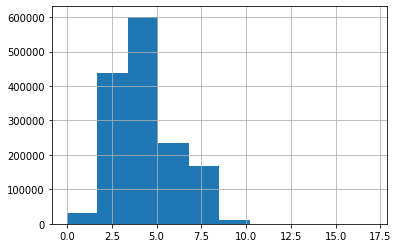

In [ ]:
# 9.3 Get histogram of distribution of seq_name lengths
#     Histogram can be used to decide where to cut-off max lengths

train.seq_name.apply(lambda x: len(x)).hist()

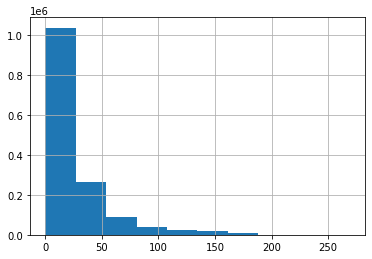

In [ ]:
# 9.4 Get histogram of distribution of seq_item_description 
#     Histogram can be used to decide where to cut-off max lengths

train.seq_item_description.apply(lambda x: len(x)).hist()

#### Get max integer values 

In [ ]:
# 10 EMBEDDINGS MAX VALUES
# 10.1 Based on the histograms, we select the max lengths
#      OR timesteps in RNN for two integer sequences, as:

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

In [ ]:
# 10.2 Vocabulary sizes of all text-sequences and all label-encoded
#      caregories
#      This would be max integer value used in any column.
#      Because conversion to integer sequence starts from 1 


# 10.2.1 Columns seq_name and seq_item_description
MAX_TEXT = np.max([np.max(train.seq_name.max()),
                   np.max(test.seq_name.max()),
                   np.max(train.seq_item_description.max()),
                   np.max(test.seq_item_description.max())
                  ]
                 ) + 2

print("Maximum integer used in MAX_TEXT: ", MAX_TEXT)

# 10.2.2 Column category_name (transformed by label encoder)
MAX_CATEGORY = np.max([
                       train.category_name.max(),
                       test.category_name.max()]
                     ) + 1


print("Maximum integer used in MAX_CATEGORY: ", MAX_CATEGORY)

# 10.2.3 Column brand_name (transformed by label encoder)
MAX_BRAND =   np.max([
                      train.brand_name.max(),
                      test.brand_name.max()
                     ]
                    ) + 1

print("Maximum integer used in MAX_BRAND: ", MAX_BRAND)

# 10.2.3 Column, item_condition, already in integer format
MAX_CONDITION = np.max([
                        train.item_condition_id.max(),
                        test.item_condition_id.max()
                        ]
                       ) + 1

print("Maximum integer used in MAX_CONDITION: ", MAX_CONDITION)

Maximum integer used in MAX_TEXT:  321998
Maximum integer used in MAX_CATEGORY:  1311
Maximum integer used in MAX_BRAND:  5290
Maximum integer used in MAX_CONDITION:  6


## Numeric fields
Scale numeric field and create a random numeric field

### Scale 'price' field
Scaled price field is called 'target'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1575a29410>]],
      dtype=object)

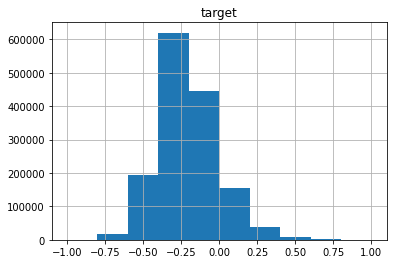

In [ ]:
# 11 Scale target variable, 'price': 
#     First take log and then scale log

# 11.1 First take a log of target. Why?
#      Make target values symmetric
train["target"] = np.log( train.price + 1)   # Add 1 to escape from -ve infinity

# 11.2 Then scale log values using min-max scaler between -1 and 1
#      Why?
#      Scaling between (-1,1) is helpful in NN modeling
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))

# 11.3 Display histogram of transformed target
#      It is quite symmetric
pd.DataFrame(train.target).hist()

### Create one more num column
This column will have random number values. The only numeric feature that we have is `'shipping'`. We will create one more  numerical column with random values for better demonstration of our proposed architecture. Otherwise, this column is NOT at all needed.


In [ ]:
# 12 Create an arbitrary column. Why?
#    We want two numerical columns for better demonstration of our
#    proposed architecture. Otherwise, this column is NOT at all needed

# 12.1 Add some small random values to shipping column and create a new column
train['ship_rand'] = train.shipping + np.random.random(size = train.shipping[0])
train.head(3)

# 12.2
test['ship_rand'] = test.shipping + np.random.random(size = test.shipping[0])
#test.head(3)

# 12.3
train.shape    # (1482535, 12)
test.shape     # (693359, 10)   Missing 'price' and its transformed column 'target'


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target,ship_rand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3878, 8988, 6978, 208, 84, 6, 155]",-0.369464,1.721413
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2667, 10, 7, 38, 17, 1, 206, 51, 19, 1098...","[11404, 27915, 17355, 2667]",0.044005,0.721413
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[596, 60, 9, 4, 5354, 11, 192, 1, 4, 900, 1298...","[7812, 10862, 666]",-0.369464,1.721413


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,seq_item_description,seq_name,ship_rand
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7,"[6, 64]","[1790, 3476, 15, 5552, 51, 4, 266, 263]",1.302715
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024, 7...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024]",1.302715
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...,"[16, 5, 315, 101, 201, 3, 21, 107, 4, 315, 3689]","[315, 101]",1.302715


(1482535, 12)

(693359, 10)

## Begin Modeling
>Split data<br>
>Expt with pad_sequences()<br>

In [ ]:
# 13. Split into train and test
#     Note that we do not have 'y' here. 
#     Why? Because 'price' is a continuous variable

# 13.1 Just 'train' will be split into two parts
#      This is permissible in sklearn syntax
dtrain, dvalid = train_test_split(train,
                                  random_state=123,
                                  train_size=0.99    # 99% vs 1%
                                 )

print(dtrain.shape)     # (1467709, 12)
print(dvalid.shape)     # (14826, 12) 1% of above

(1467709, 12)
(14826, 12)


### Experiment with pad_sequences
Our dataset has:<br>
> 1. Categorical columns
>> Three integer columns: <b>item_condition_id</b>, <b>category_name</b> and <b>brand_name</b><br>
>> Two columns (of integer sequences): <b>seq_item_description</b> and <b>seq_name</b><br>

> 2. Numeric columns (two): <b>shipping, ship_rand</b><br>
> 3. Target column 'target'<br>

Thus total number of columns are: 3 +2 + 2+ 1 = 8


In [ ]:
# Just have a look at the train data:
dtrain.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target,ship_rand
407853,407853,maroon velvet lisette shorts,1,1162,737,22.0,1,brand new from brandy melville,"[16, 5, 43, 537, 586]","[825, 1027, 17236, 129]",-0.175509,1.721413
748699,748699,Benefit Roller Lash Mascara FULL SIZE,2,26,574,14.0,1,Benefit Roller Lash Mascara FULL SIZE in the c...,"[1238, 2566, 1266, 641, 153, 6, 7, 2, 48, 24, ...","[1238, 2566, 1266, 641, 153, 6]",-0.287907,1.721413
320295,320295,Holographic Ipsy Bag,2,1303,5265,7.0,0,Used once,"[31, 96]","[2896, 2224, 101]",-0.453202,0.721413


Integer sequence columns `seq_item_description` and `seq_name` must have sequences of equal length. So we pad-sequences in each column. Here is what padding does.

In [ ]:
# Use keras pad_sequences function:

print(f" Max size of sequence: {MAX_NAME_SEQ}")
print(f" Shape of dtrain.seq_name: {dtrain.seq_name.shape}")

s = pad_sequences(
                   dtrain.seq_name,
                   maxlen=MAX_NAME_SEQ
                  )

 Max size of sequence: 10
 Shape of dtrain.seq_name: (1467709,)


In [ ]:
# As s will be a numpy array
#  to observe it let us transorm it
#   into pandas dataframe:

print(f"Shape of s: {s.shape}")

# Here is dataframe:
pd.DataFrame(s).head(3)

Shape of s: (1467709, 10)


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,825,1027,17236,129
1,0,0,0,0,1238,2566,1266,641,153,6
2,0,0,0,0,0,0,0,2896,2224,101


### Define a function to create a dictionary of data
That is we are sort of transforming pandas dataframe to a dictionary as per our conveience


In [ ]:
# 13.2 Define a function that creates a dictionary of array values 
#      to help to feed data into keras
#      All columns but the last 'num_vars' are categorical
#      WE have SIX columns or column-sets here
def get_keras_data(dataset):
    X = {   
        'name':           pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),                             # 1
        'item_desc':      pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),            # 2
        'brand_name':     np.array(dataset.brand_name),                                                     # 3
        'category_name':  dataset.category_name.values,                                                  # 4
        'item_condition': dataset.item_condition_id.values,                                              # 5
        'num_vars':       np.array(dataset[["shipping", "ship_rand"]])    # Two numeric columns here        # 6
    }
    return X


In [ ]:
# 13.3 Get these datasets now
X_train = get_keras_data(dtrain)  # type: dict
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [ ]:
# 13.4 Just check shapes. We need these below
print(X_train["name"][:4])
print("\n===========")
print(X_train["name"].shape)

In [ ]:
# 13.5 Just check shapes. We need these below
print(X_train["item_desc"][:4])
print("\n===========")
print(X_train["item_desc"].shape)

In [ ]:
# 13.6 Just check shapes. We need these below
X_train["num_vars"][:4]
X_train["num_vars"].shape[1]       # 2

## Convert categorical columns to word-vectors
### A
Consider following sentences:<br><p>
1. mango is sweet<br>
2. apple is sweet<br>
3. mouse moves pointer<br>
4. iphone mobile is used for communication<br>

An embedding layer will convert word to vectors to discover relationship among words. Or, one can say that conversion of a word to vectors, facilitates finding association between context words. Examples are: <br>

(mango, sweet), (apple, sweet), (mouse,pointer), (iphone,mobile) <br>

### B
Now, consider the following table with three categorical columns: <br>

| x1   |   x2    |   x3    |
|------|---------|---------|  
|mango |  tree   |  sweet  |
|apple |  tree   |  sweet  |
|mouse | pointer |  moves  |
|iphone| mobile  |communication|

Conversion of categorical values to word-vectors helps discover better association between mango and sweet OR mango and tree OR mouse and pointer etc than by simply label encoding them and applying machine learning algo to discover patterns.

In [4]:
# 14.2 Define callback function for earlystopping and storing weights
#      May forget this in the first reading
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


In [ ]:
# 14.3 Forget it in first reading. Another loss function
#      Any functions used in the model must use tensors
#      and not numpy arrays. Of course, dataset can be numpy
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [ ]:
# 14.1 Sizes of categorical values AND word to vectors
#      Sizes?
word2vec_size = 50
cat2vec_size = 10
cond2vec_size = 5

In [ ]:
# 14.4 Our model
def get_model():
    
    # 14.1 Level of dropouts: 10%
    dr_r = 0.1   
    
    # 14.2 SIX Inputs. At each input specify number of input-features 
    name =            Input(shape=[X_train["name"].shape[1]],      name="name")
    item_desc =       Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name =      Input(shape=[1],                             name="brand_name")  # Just 1 feature.Hence shape=[1]
    category_name =   Input(shape=[1],                             name="category_name") # Just 1 feature.Hence shape=[1]
    item_condition =  Input(shape=[1],                             name="item_condition") # Just 1 feature. Hence shape = [1]
    num_vars =        Input(shape=[X_train["num_vars"].shape[1]],  name="num_vars")
    
    # 14.3 FIVE Embeddings layers.  Embedding vectors of first FIVE of the above
    
    # 14.3.1 Output of following two also go in RNN.
    #        RNN output needs no flattening as this output is received
    #        AFTER all timesteps have been fed into RNN
    emb_name =           Embedding(MAX_TEXT,      word2vec_size  )(name)               
    emb_item_desc =      Embedding(MAX_TEXT,      word2vec_size  )(item_desc)
    
    # 14.3.2 Output of following three go directly into Dense layer after flattening
    #        These need to be flattened as for every timestep there is a vector
    emb_brand_name =     Embedding(MAX_BRAND,     cat2vec_size  )(brand_name)
    emb_category_name =  Embedding(MAX_CATEGORY,  cat2vec_size  )(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, cond2vec_size )(item_condition)
    
    # 14.4 TWO RNN layers. Both these are independent of each other. 
    rnn_layer2 = GRU(8) (emb_name)          # Output of GRU is a vector of size 8
    rnn_layer1 = GRU(16) (emb_item_desc)    # Output of GRU is a vector of size 16
    
    # 15. Concatenate all layer-branches 
    main_l = concatenate([
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                          ]
                         )
    
    # 15.1 Add classification layer
    main_l = Dense(128) (main_l)
    main_l = Dropout(dr_r)(main_l)
    main_l = Dense(64) (main_l)
    main_l = Dropout(dr_r) (main_l)
    
    # 15.2 Output neuron
    output = Dense(1, activation="linear") (main_l)
    
    # 15.3 Formulate Model now
    model = Model(
                  inputs= [name, item_desc, brand_name,category_name, item_condition, num_vars],
                  outputs= output
                 )
    # 15.4
    model.compile(loss="mse",
                  optimizer="adam",
                  metrics=["mae", rmsle_cust]    # Note two metrics here. First reading confine to 'mae' only
                 )
    return model


# 16 Formulate model and show summary    
model = get_model()
model.summary()
    


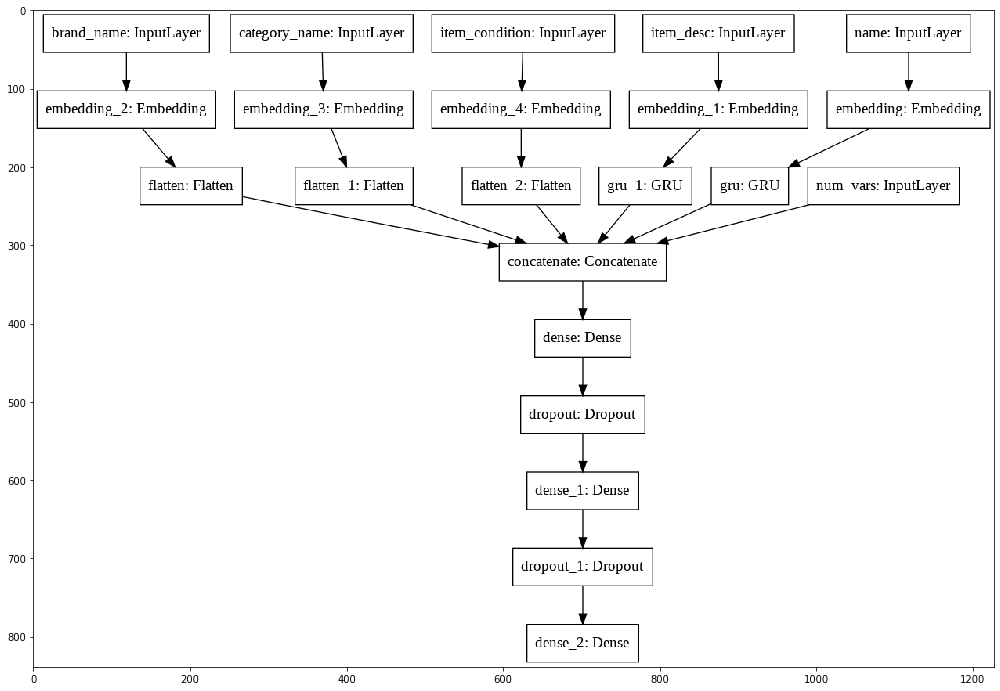

In [ ]:
# 16.1 Plot the model architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model, to_file = "model.png");
io.imshow("model.png");

In [ ]:
# 17. Training the model
BATCH_SIZE = 20000
epochs = 5
model = get_model()

# 17.1
start = time.time()
history= model.fit(X_train,
                   dtrain.target,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
                   validation_data=(X_valid, dvalid.target),
                   verbose=1
                  )

end = time.time()
print((end-start)/60)    # Five epochs take 15 minutes

In [ ]:
# 18 Evaluate model using validation data
val_preds = model.predict(X_valid)
# 18.1 Undo transformation by MinMaxScaler
val_preds = target_scaler.inverse_transform(val_preds)  
# 18.2 Undo logs
val_preds = np.exp(val_preds) - 1   # It should be -1. Original code has +1
val_preds[:10]     # (10,1)
val_preds[:10, 0]  # Convert to 1D
y_pred = val_preds[:,0]

# 19. Mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_true[:10]

# 19.1
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4693206202824715


In [ ]:
########### I am done #############
# Optional

# 20. Create Predictions on test data
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

# 20.1
submission = test[["test_id"]]
submission["price"] = preds

In [ ]:
# 20.2 Should you want to submit on 
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()


This was just an example how nn can solve this problems. Potencial improvements of the kernel:
    - Increase the embeddings factors
    - Decrease the batch size
    - Add Batch Normalization
    - Try LSTM, Bidirectional RNN, stack RNN
    - Try with more dense layers or more rnn outputs
    -  etc. Or even try a new architecture!